# Different ways to fit data with ADE-DG toolbox


Example template for fitting with scipy.optimize.curve_fit
and with an analytical solution

De and alpha/porosity is fitted with synthetic dataset 

For this case it is assumed that upstream and downstream reservoir concentrations are constant!

georg.kosakowski@psi.ch 18 July 2025

In [1]:
import sys
import time
import os
import math
import numpy as np
import scipy as sc
import pandas as pd
from copy import copy

In [2]:
# import numerical toolbox ADE_DG for solving Advection-Diffusion-Equation specifically for trough-diffusion experiments
#import sys
sys.path.append("../../sources") # include path to ../../sources/ADE_DG1.py in path! -> this notebook is in ../notebooks/

# ADE_DG1.py must be in the path -> see path settings above
import ADE_DG
from ADE_DG import BoundaryCondition as BoundaryCondition # import BoundaryCondition in this way, otherwise it is not available ...

## Create synthetic experimental data

Use an analytical solution to calculate an ideal solution and then perturb it by randomly shifting the datapoints.



In [3]:
# analytical solution from NTB 02-15 
def down_flux(t,alpha,De):
    print("analytic_model: called with alpha,De",alpha,De)
    L=0.012
    C0=1.0
    #porosity=0.1
    #De=1.0e-11
    #alpha=0.1
    dummy=0.0
    for i in range(1,20):  # summ up negative and positive sources...increase number of sources for very long times...
        dummy=dummy  +  np.pow(-1.0,i) * np.exp(-1.0*i*i*np.pi*np.pi*De/alpha*t/(L*L))
    flux=C0*De/L*(1.0+2.0*dummy)  
    #print("Debug analytical: alpha, De",alpha,De)
    return flux

# create array with times
# create list with numbers from 0 to n-1
n=25
dummy = list(range(1,n+1))
tdat = np.array(dummy)*5e4+2.0e4
# calculate downstream fluxes from analytical solution for porosity=0.1, De=1e-11
fdat=down_flux(tdat,0.1,1e-11)
# add noise ....see scipy.optimize.curve_fit documentation
rng = np.random.default_rng()
y_noise = rng.normal(size=fdat.size) # this corresponds to standard normal distribution with sd=1 -> +- 2 sd gives 95% percentiles 
fdat=fdat *(1+0.1*y_noise) # scale noise such that 2 SD is 20% of flux value
# fdat=fdat *(1+0.0*y_noise) # scale to zero noise 

# add experimental uncertainties
udat = fdat*abs(0.1 + np.random.normal(size=fdat.size, scale=0.05))

display(tdat,fdat,udat)

analytic_model: called with alpha,De 0.1 1e-11


array([  70000.,  120000.,  170000.,  220000.,  270000.,  320000.,
        370000.,  420000.,  470000.,  520000.,  570000.,  620000.,
        670000.,  720000.,  770000.,  820000.,  870000.,  920000.,
        970000., 1020000., 1070000., 1120000., 1170000., 1220000.,
       1270000.])

array([2.55343580e-11, 1.63863311e-10, 3.76600209e-10, 4.73561796e-10,
       5.97695542e-10, 6.45056952e-10, 7.41899017e-10, 7.94033978e-10,
       7.10418168e-10, 8.73528416e-10, 8.86405546e-10, 7.91168582e-10,
       6.75737933e-10, 6.95183892e-10, 8.68408359e-10, 7.19174606e-10,
       6.66125746e-10, 8.39284126e-10, 9.57226521e-10, 7.53622885e-10,
       8.19529571e-10, 7.80247440e-10, 7.15647418e-10, 7.07371062e-10,
       7.40625496e-10])

array([3.80531055e-12, 2.93929395e-11, 4.56497376e-11, 4.32425003e-11,
       2.72173891e-11, 7.94961398e-11, 9.85191646e-11, 9.25014394e-11,
       5.54245190e-11, 1.18951941e-10, 9.85566397e-11, 1.04829468e-10,
       6.14319279e-12, 7.84347555e-11, 1.30867938e-10, 4.98589270e-11,
       8.21278615e-11, 3.40964744e-11, 7.84257167e-11, 3.99944805e-11,
       4.58324847e-11, 2.51291949e-10, 5.64746361e-11, 5.53903627e-11,
       9.30401559e-11])

## Create and initialize function for numerical solver with ADE_DG

One has to initialize and create a function that can be called from the fitting routine. 

The basic setup is based on mesh that was created with gmsh:

    * The dimensions of the mesh should be choosen that they represent the dimensions of the diffusion cell, filters, sample.
    * The different materials (sample, filter) and the influx (upstream) and outflux (downstream) boundaries have to be marked with "physical group Ids"
    * It is assumed the the upstream boundary is at x=0m and the downstream boundary at x = "lenght of sample + filters" in positive x-direction

The numerical solver is initialized via the ADE_DG call that reads the mesh from a file and requires a parameter that sets the "degree" of DG elements.

For the numerical setup the follwing parameters have to be defined and passed to the code:

    * material parameters
        - De and porosity/alpha for all materials (filter,sample)
        - Cross sectional area of the sample/filters
    * initial conditions
       - Initial concentrations everywhere in the domain
    * boundary conditions
        - position of the boundaries and their physical group id (marker no.)
        - initial concentrations in the Upstream and Downstream reservoirs
        - volume of the reservoirs
        - A flag that sets constant (boundary) concentrations in the reservoir: set_reservoir_boundaries(False), 
        or adjusts reservoir concentrations according to fluxes out of or into the reservoir: set_reservoir_boundaries(True)
        


In [4]:
# general definitions    
hour=3600.0
day=hour*24.0
year=day*365.25

# filename for gmsh file
mymesh_filename = "../../notebooks/gmsh/untitled.msh"
# define problem
# degree of desired FE is moved into ADE_DG
problem = ADE_DG.ADE_DG(mymesh_filename,deg=2)
# define everything once
# effective Diffusion for all marked materials
# markers can be found in gmsh geo file
De=1.0e-11
De_dict={
    11 : De,   #filter
    12 : De   #sample
}

# porosity
alpha=0.1
porosity_dict={
    11 : alpha,  #filter
    12 : alpha    #sample
}
# if diffusion only the Darcy flux is 0.0 (zero) for all components
darcy_flux_vector = (0.0,0.0) # list  will work ...

# initial condition
C0=0.0
problem.set_initial_conditions(C0)

# set upstream concentration
upstream_concentration=1.0

# to reset downstream concentration to "zero" we create an array of times 
#t_down_rest=[1.0e11] # only some random entries..very large time to avoid re-setting concentrations
t_down_rest=tdat # they can be also used for giving exact times that should be hit/output during time stepping 

problem.set_darcy_flux(darcy_flux_vector)
problem.set_De(De_dict)
problem.set_porosity(porosity_dict)
# write materials in specific vtx file (do not use the same file as for time steps. this will overwrite file=
#problem.vtx_write_materials(filename_vtx_materials,t=0.0) 
upstream_boundary_id=13
upstream_boundary_x=0.0
problem.set_upstream_boundary(upstream_boundary_id,upstream_boundary_x) # should be "left boundary"
problem.set_upstream_reservoir_concentration(upstream_concentration)
problem.set_upstream_reservoir_volume(1.0)
downstream_boundary_id=14
downstream_boundary_x=0.012
problem.set_downstream_boundary(downstream_boundary_id,downstream_boundary_x) # should be "right  boundary"
problem.set_downstream_reservoir_concentration(0.0)
problem.set_downstream_reservoir_volume(1.0)
problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
problem.set_cross_section_area(1.0) # 1 for comparison with analytical solution
problem.set_tol_adaptive(1.0e-3) # tolerance for adaptive time stepping..we use a value that works with normalization of solution

INFO:root:INFO: init with: ../../notebooks/gmsh/untitled.msh deg 2
INFO:root:INFO: mesh read! mesh dimension: 2 boundary dimension 1 geometry dimension: 2
INFO:root:INFO: De set via dictionary {11: 1e-11, 12: 1e-11} default: 1.0e-11 
INFO:root:porosity set via dictionary {11: 0.1, 12: 0.1}default: 1.0


Info    : Reading '../../notebooks/gmsh/untitled.msh'...
Info    : 21 entities
Info    : 336 nodes
Info    : 670 elements
Info    : Done reading '../../notebooks/gmsh/untitled.msh'


The next cell contains the wrapper function for running the ADE-DG diffusion solver repeatedly with different rock capacity factor / porosity and effective diffusion coefficient. Please note, that for each run not only De and alpha, but also the correct initial conditions and boundary conditions have to be set.

In [5]:
def flux_model(tdat,alpha,De):
    print("numerical_model: called with alpha,De",alpha,De)

    # set normalization_factor
    normalization_factor=upstream_concentration
    # this can be moved out of the loop , at least in principle
    #problem.set_update_reservoir_boundaries(False) # if up-stream and down-stream reservoirs should be defined ..needs defintion of reservoir properties
    problem.set_upstream_boundary(upstream_boundary_id,upstream_boundary_x) # should be "left boundary"
    problem.set_downstream_boundary(downstream_boundary_id,downstream_boundary_x) # should be "right  boundary"
#    problem.set_tol_adaptive(1.0e-8)  
    #### definitions for ADE-DG solutions that need to be re-set for multiple runs
    # only reset everything that is changed during simulations or due to call -> alpha
    C0=0.0 # initial concentration 
    
    De_dict={
        11 : De,   #filter
        12 : De   #sample
    }
    
    # porosity
    porosity_dict={
        11 : alpha,  #filter
        12 : alpha    #sample
    }
    u_old=problem.set_initial_conditions(C0/normalization_factor)
    
    problem.set_porosity(porosity_dict)
    problem.set_De(De_dict)
    
    problem.set_downstream_reservoir_exchange_solution_times(t_down_rest)
    problem.set_upstream_reservoir_concentration(upstream_concentration/normalization_factor)    
    problem.set_downstream_reservoir_concentration(0.0/normalization_factor)
    
    # Time stepping
    t_end=max(tdat)
    dt=1000.0
    problem.set_dt(dt)
    problem.set_T_end(t_end)

    solution,data=problem.solve_adaptive_timesteps()
    #solution,data=problem.solve_timesteps() # fixed time stepping scheme! solution is fenics Function(V) object, while data is a pandas data frame
    # add integrates downstream fluxes for fitting
    data['Downstream_flux_integr']=sc.integrate.cumulative_trapezoid(data.Downstream_flux,data.time,initial=0.0) # fluxes and concentrations need to be scaled back if used directly...

    solution.x.array[:]=solution.x.array[:]*normalization_factor
    data.iloc[:,2:]=data.iloc[0:,2:]* normalization_factor
    # for time interpolation we can use np.interpolate
    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux))

# for fitting integrated data!
#    flux=np.interp(tdat, data.time, np.abs(data.Downstream_flux_integr)) 


    #print("Debug: solution, data, flux ",solution,data,flux)
    return (flux) 

In [6]:
problem.set_logging_level("INFO") # This gives some information on time steps and time step sizes!
problem.set_tol_adaptive(1.0e-7) # tolerance for adaptive time stepping..we use a value that works with normalization of solution
flux=flux_model(tdat,alpha,De)
#print(flux)

INFO:root:porosity set via dictionary {11: 0.1, 12: 0.1}default: 1.0
INFO:root:INFO: De set via dictionary {11: 1e-11, 12: 1e-11} default: 1.0e-11 


set logging to level:  INFO
numerical_model: called with alpha,De 0.1 1e-11


INFO:root:INFO: Adaptive time loop starts with error tolerance: 1e-07 update_reservoir_concentrations: False
INFO:root:INFO: t dt error est     0.0000 |     0.0101 |  9.984e-08
INFO:root:INFO: t dt error est     0.0101 |     0.0096 |  2.265e-10
INFO:root:INFO: t dt error est     0.0197 |     0.1029 |  9.323e-08
INFO:root:INFO: t dt error est     0.1226 |     0.1011 |  2.593e-08
INFO:root:INFO: t dt error est     0.2238 |     0.1884 |  4.417e-08
INFO:root:INFO: t dt error est     0.4122 |     0.2690 |  3.151e-08
INFO:root:INFO: t dt error est     0.6812 |     0.4546 |  3.273e-08
INFO:root:INFO: t dt error est     1.1357 |     0.7538 |  5.040e-08
INFO:root:INFO: t dt error est     1.8895 |     1.0073 |  4.395e-08
INFO:root:INFO: t dt error est     2.8968 |     1.4415 |  4.021e-08
INFO:root:INFO: t dt error est     4.3383 |     2.1567 |  3.774e-08
INFO:root:INFO: t dt error est     6.4951 |     3.3304 |  4.749e-08
INFO:root:INFO: t dt error est     9.8254 |     4.5848 |  4.651e-08
INFO:ro

## Fitting with scipy optimize.curve_fit

### Fit with ADE-DG

- it seems that the "accuracy" of the numerical solution (probably related to non-optimized mesh and time stepping) is not good enough to do fitting with standard lm method and default settings. What works so far is the 'dogbox' method with diff_step=[1e-2], boundas and scaling of De values with x_scale=1e10.

from documentation of least-square method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares

‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use case is small problems with bounds. Not recommended for problems with rank-deficient Jacobian

For the meaning of the diagnostic output 

In [7]:
# set logging level for ADE_DG to ERROR
# INFO would give to much information
problem.set_logging_level("ERROR")

# fit data

start=[0.15,2e-11]

# scale flux data: multiply with 1e10
# fit the log data!
#popht, pcovht, infodict, mesg, ier = sc.optimize.curve_fit(flux_model, (tdat), (fdat),p0= [start],full_output=True,method='lm') #,bounds=[0.05,0.15])

popht, pcovht, infodict, mesg, ier = sc.optimize.curve_fit(flux_model, (tdat), (fdat),p0= start,full_output=True,check_finite=True,x_scale=1e10,method='dogbox',diff_step=[1e-2],bounds=((1.0e-5,1.0e-16),(3.0,1.0e-9))) #,
print("Fitting result: analytic fit: Fitted values ",popht," one standard deviation errors parameter estimates",np.sqrt(np.diag(pcovht)),
      " \n residual values (fvec), Jacobian Matrix (fjac), The number of function calls (nfev)  see documentation for other values: ",
      infodict," \n A string message giving information about the solution: ",mesg," \n An integer flag. If it is equal to 1, 2, 3 or 4, the solution was found:",ier) # for calculation of std. error for fitted parameters callnp.sqrt(np.diag(pcov))

set logging to level:  ERROR
numerical_model: called with alpha,De 0.15 2e-11
numerical_model: called with alpha,De 0.1515 2e-11
numerical_model: called with alpha,De 0.15 2.02e-11
numerical_model: called with alpha,De 0.09340463672421194 9.389822207715335e-12
numerical_model: called with alpha,De 0.09433868309145406 9.389822207715335e-12
numerical_model: called with alpha,De 0.09340463672421194 9.483720429792488e-12
Fitting result: analytic fit: Fitted values  [9.34046367e-02 9.38982221e-12]  one standard deviation errors parameter estimates [9.18918283e-03 2.32423895e-13]  
 residual values (fvec), Jacobian Matrix (fjac), The number of function calls (nfev)  see documentation for other values:  {'nfev': 2, 'fvec': array([ 2.83808327e-11,  6.76035417e-11,  2.70441225e-11,  5.01988695e-11,
        8.58509282e-12,  1.77035406e-11, -4.08576690e-11, -6.72787406e-11,
        3.34435970e-11, -1.17924304e-10, -1.23070012e-10, -2.23824699e-11,
        9.71368161e-11,  8.06236875e-11, -9.07584

### Fit with analytical solution

The fit with the analytical solution works in the same way. Here the standard lm method works fine. And of course the fit is much faster ;-)

‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. Usually the most efficient method for small unconstrained problems.


In [8]:
popht1, pcovht1, infodict1, mesg1, ier1 = sc.optimize.curve_fit(down_flux, (tdat), (fdat),p0= start,full_output=True,check_finite=True,x_scale=1e10,method='dogbox',diff_step=[1e-2],bounds=((1.0e-5,1.0e-16),(3.0,1.0e-9))) #,
print("Fitting result: analytic fit: Fitted values ",popht1," one standard deviation errorsof parameter estimates",np.sqrt(np.diag(pcovht1)),
      " \n residual values (fvec), Jacobian Matrix (fjac), The number of function calls (nfev)  see documentation for other values: ",
      infodict1," \n A string message giving information about the solution: ",mesg1," \n An integer flag. If it is equal to 1, 2, 3 or 4, the solution was found:",ier1) # for calculation of std. error for fitted parameters callnp.sqrt(np.diag(pcov))

analytic_model: called with alpha,De 0.15 2e-11
analytic_model: called with alpha,De 0.1515 2e-11
analytic_model: called with alpha,De 0.15 2.02e-11
analytic_model: called with alpha,De 0.08305967278388776 9.428452576911929e-12
analytic_model: called with alpha,De 0.08389026951172664 9.428452576911929e-12
analytic_model: called with alpha,De 0.08305967278388776 9.522737102681047e-12
Fitting result: analytic fit: Fitted values  [8.30596728e-02 9.42845258e-12]  one standard deviation errorsof parameter estimates [7.77786131e-03 2.25827348e-13]  
 residual values (fvec), Jacobian Matrix (fjac), The number of function calls (nfev)  see documentation for other values:  {'nfev': 2, 'fvec': array([ 1.51299528e-11,  4.12569003e-11, -1.66644216e-12,  3.00619788e-11,
       -3.94508184e-12,  1.03900891e-11, -4.45085850e-11, -6.81898869e-11,
        3.47155835e-11, -1.15320273e-10, -1.19336245e-10, -1.80937587e-11,
        1.01407021e-10,  8.47195124e-11, -8.66354713e-11,  6.38652861e-11,
       

### Plotting results for both fits

For plotting we need the actual values for the optimal solution, so we calculate fluxes for given times with best fit values for analytical and numerical model.
And we have a very simple method to calculate upper lower bounding fits by using variance of parameter estimation ...


In [9]:
model_ade=flux_model(tdat,*popht )

numerical_model: called with alpha,De 0.09340463672421194 9.389822207715335e-12


In [10]:
model_analytic=down_flux(tdat,*popht1)
variance_analytic=np.sqrt(np.diag(pcovht1))
SD_analytic=(np.sqrt(np.diag(pcovht1)))
# calculate some bounding cases...the hard way ;-)
Dmin=popht1[1]-3*SD_analytic[1]
Dmax=popht1[1]+3*SD_analytic[1]
alphamin=popht1[0]-3*SD_analytic[0]
alphamax=popht1[0]+3*SD_analytic[0]
mod_Dmin_alphamin=down_flux(tdat,alphamin,Dmin)
mod_Dmin_alphamax=down_flux(tdat,alphamax,Dmin)
mod_Dmax_alphamin=down_flux(tdat,alphamin,Dmax)
mod_Dmax_alphamax=down_flux(tdat,alphamax,Dmax)


analytic_model: called with alpha,De 0.08305967278388776 9.428452576911929e-12
analytic_model: called with alpha,De 0.05972608884845499 8.75097053326764e-12
analytic_model: called with alpha,De 0.10639325671932054 8.75097053326764e-12
analytic_model: called with alpha,De 0.05972608884845499 1.0105934620556217e-11
analytic_model: called with alpha,De 0.10639325671932054 1.0105934620556217e-11


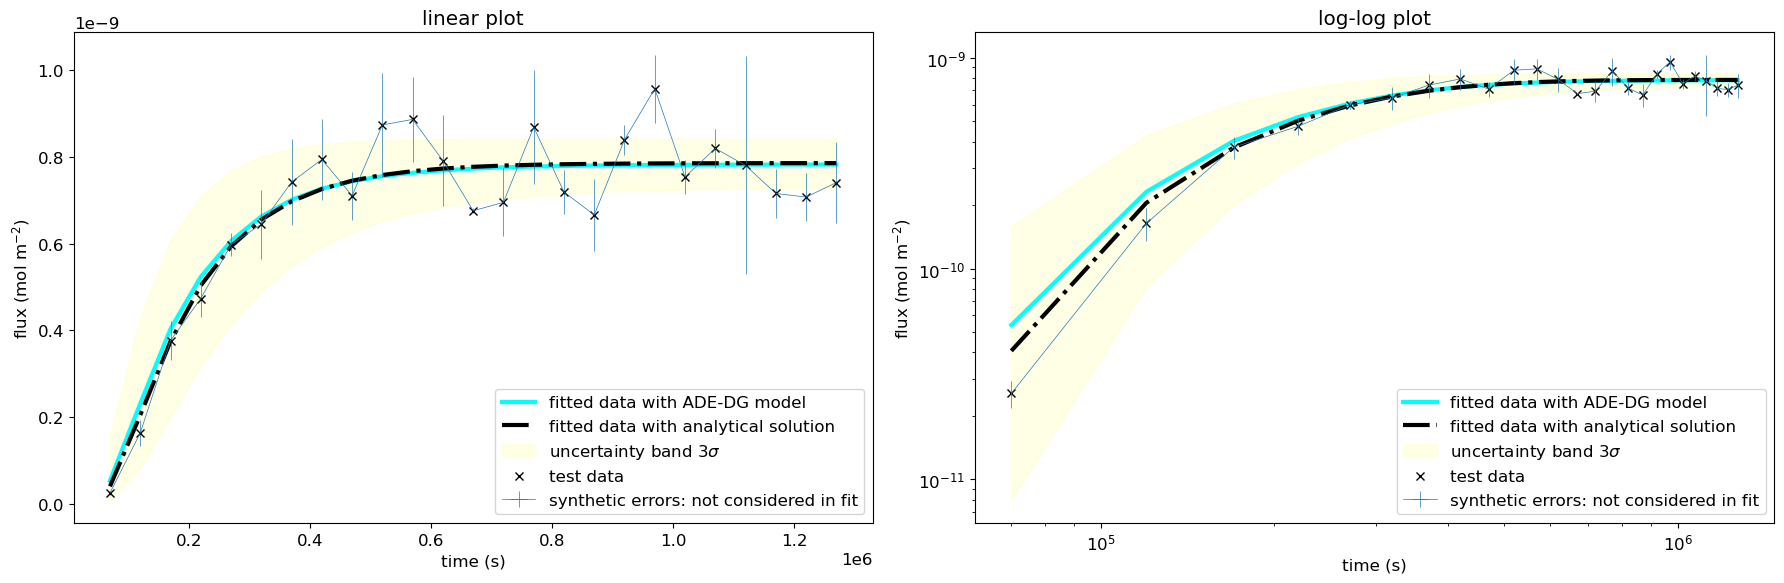

In [11]:
# firs we plot the fluxes ...aka breakthrough
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)
plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

fig, (ax0, ax1) = plt.subplots(1, 2) # two sub figures 

####### linear plot ##########
ax0.set_title('linear plot')

ax0.plot(tdat,model_ade,linestyle='-',color="cyan",label='fitted data with ADE-DG model')
ax0.plot(tdat,model_analytic,linestyle='-.',color="black",label='fitted data with analytical solution')

alph=0.5 # transparancy
# plot some bounding cases
#ax0.plot(tdat,mod_Dmax_alphamax,linestyle='-',color="red",alpha=alph,label='Analytical solution: Alpha+2SD, De+2SD')
#ax0.plot(tdat,mod_Dmin_alphamax,linestyle='-',color="orange",alpha=alph,label='Analytical solution: Alpha+2SD, De-2SD')
#ax0.plot(tdat,mod_Dmax_alphamin,linestyle='-',color="yellow",alpha=alph,label='Analytical solution: Alpha-2SD, De+2SD')
#ax0.plot(tdat,mod_Dmin_alphamin,linestyle='-',color="pink",alpha=alph,label='Analytical solution: Alpha-2SD, De-2SD')
ax0.fill_between(tdat, mod_Dmax_alphamin, mod_Dmin_alphamax, alpha=0.1, color='yellow',label=r"uncertainty band 3$\sigma$")

ax0.errorbar(tdat, fdat, xerr=0.0, yerr=udat,linewidth=0.5,label='synthetic errors: not considered in fit')
ax0.plot(tdat, fdat, label='test data', color="black",linestyle='',marker='x',linewidth=1.0)

#ax0.set_xlim(0.0,0.012)
#ax0.set_ylim(1e-16,1e-11)

#ax[0,0].set_ylim(-0.2, 1.4)
#ax[0,0].set_xlim(0, 1.0)

ax0.set_xlabel('time (s)')
ax0.set_ylabel(r'flux (mol m$^{-2}$)') # use latex style for formatting

ax0.legend(loc='lower right')
####### log-log plot ##########
ax1.set_title('log-log plot')

ax1.plot(tdat,model_ade,linestyle='-',color="cyan",label='fitted data with ADE-DG model')
ax1.plot(tdat,model_analytic,linestyle='-.',color="black",label='fitted data with analytical solution')
# plot some bounding cases
#ax1.plot(tdat,mod_Dmax_alphamax,linestyle='-',color="red",alpha=alph,label='Analytical solution: Alpha+2SD, De+2SD')
#ax1.plot(tdat,mod_Dmin_alphamax,linestyle='-',color="orange",alpha=alph,label='Analytical solution: Alpha+2SD, De-2SD')
#ax1.plot(tdat,mod_Dmax_alphamin,linestyle='-',color="yellow",alpha=alph,label='Analytical solution: Alpha-2SD, De+2SD')
#ax1.plot(tdat,mod_Dmin_alphamin,linestyle='-',color="pink",alpha=alph,label='Analytical solution: Alpha-2SD, De-2SD')
ax1.fill_between(tdat, mod_Dmax_alphamin, mod_Dmin_alphamax, alpha=0.1, color='yellow',label=r"uncertainty band 3$\sigma$")

ax1.plot(tdat, fdat, label='test data', color="black",linestyle='',marker='x',linewidth=1.0)
ax1.errorbar(tdat, fdat, xerr=0.0, yerr=udat,linewidth=0.5,label='synthetic errors: not considered in fit')

ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'flux (mol m$^{-2}$)') # use latex style for formatting

ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.set_xlim(0.0,0.012)
#ax1.set_ylim(1e-16,1e-11)

#ax[0,0].set_ylim(-0.2, 1.4)
#ax[0,0].set_xlim(0, 1.0)
ax1.legend(loc='lower right')


plt.tight_layout()  # no excess boundaries
plt.show() 


## Fitting with LMFIT

https://lmfit.github.io/lmfit-py/intro.html

The lmfit package provides simple tools to help you build complex fitting models for non-linear least-squares problems and apply these models to real data.

**Install lmfit-py with** **"mamba install lmfit"**

Why use lmfit?

While scipy offers an standard approach to optimization and curve fitting, LMFIT is a specialised tool that offers better support for advanced methods and diagnostic tools!


In [12]:
### Fit with ADE-DG model

In [13]:

import lmfit as lmfit

params = lmfit.Parameters()
params.add('alpha', 0.2) # starting value for fit
params.add('De', value=3.0e-11) # starting value for fit


analytic=lmfit.Model(down_flux)
print(f'parameter names: {analytic.param_names}')
print(f'independent variables: {analytic.independent_vars}')

result_analytic=analytic.fit(fdat, t=tdat, alpha=0.2,De=3.0e-11)


print(result_analytic.fit_report())

#lmfit.printfuncs.report_fit(out_analytic.params, min_correl=0.5)
dely_analytic = result_analytic.eval_uncertainty(sigma=3) # for uncertainties

parameter names: ['alpha', 'De']
independent variables: ['t']
analytic_model: called with alpha,De 0.2 3e-11
analytic_model: called with alpha,De 0.2 3e-11
analytic_model: called with alpha,De 0.2 3e-11
analytic_model: called with alpha,De 0.2 3e-11
analytic_model: called with alpha,De 0.200002 3e-11
analytic_model: called with alpha,De 0.2 3.00003e-11
analytic_model: called with alpha,De 0.08248905635371262 9.4105986670792e-12
analytic_model: called with alpha,De 0.08248988124427616 9.4105986670792e-12
analytic_model: called with alpha,De 0.08248905635371262 9.41069277306587e-12
analytic_model: called with alpha,De 0.08352593425998041 9.451167678430544e-12
analytic_model: called with alpha,De 0.083526769519323 9.451167678430544e-12
analytic_model: called with alpha,De 0.08352593425998041 9.451262190107329e-12
analytic_model: called with alpha,De 0.08344666880044256 9.450100825948192e-12
analytic_model: called with alpha,De 0.08344750326713056 9.450100825948192e-12
analytic_model: call

In [14]:
# this takes some time to run!

ademodel=lmfit.Model(flux_model)
print(f'parameter names: {ademodel.param_names}')
print(f'independent variables: {ademodel.independent_vars}')

result_ademodel=ademodel.fit(fdat, tdat=tdat, alpha=0.2,De=3.0e-11)


print(result_ademodel.fit_report())
dely_ade = result_ademodel.eval_uncertainty(sigma=3) # for uncertainties

parameter names: ['alpha', 'De']
independent variables: ['tdat']
numerical_model: called with alpha,De 0.2 3e-11
numerical_model: called with alpha,De 0.2 3e-11
numerical_model: called with alpha,De 0.2 3e-11
numerical_model: called with alpha,De 0.2 3e-11
numerical_model: called with alpha,De 0.200002 3e-11
numerical_model: called with alpha,De 0.2 3.00003e-11
numerical_model: called with alpha,De 0.0944633660317599 9.339352703099298e-12
numerical_model: called with alpha,De 0.09446431066542021 9.339352703099298e-12
numerical_model: called with alpha,De 0.0944633660317599 9.33944609662633e-12
numerical_model: called with alpha,De 0.09952016136418258 9.482150878606636e-12
numerical_model: called with alpha,De 0.09952115656579623 9.482150878606636e-12
numerical_model: called with alpha,De 0.09952016136418258 9.482245700115422e-12
numerical_model: called with alpha,De 0.09943881872718566 9.481026198331936e-12
numerical_model: called with alpha,De 0.09943981311537294 9.481026198331936e-12

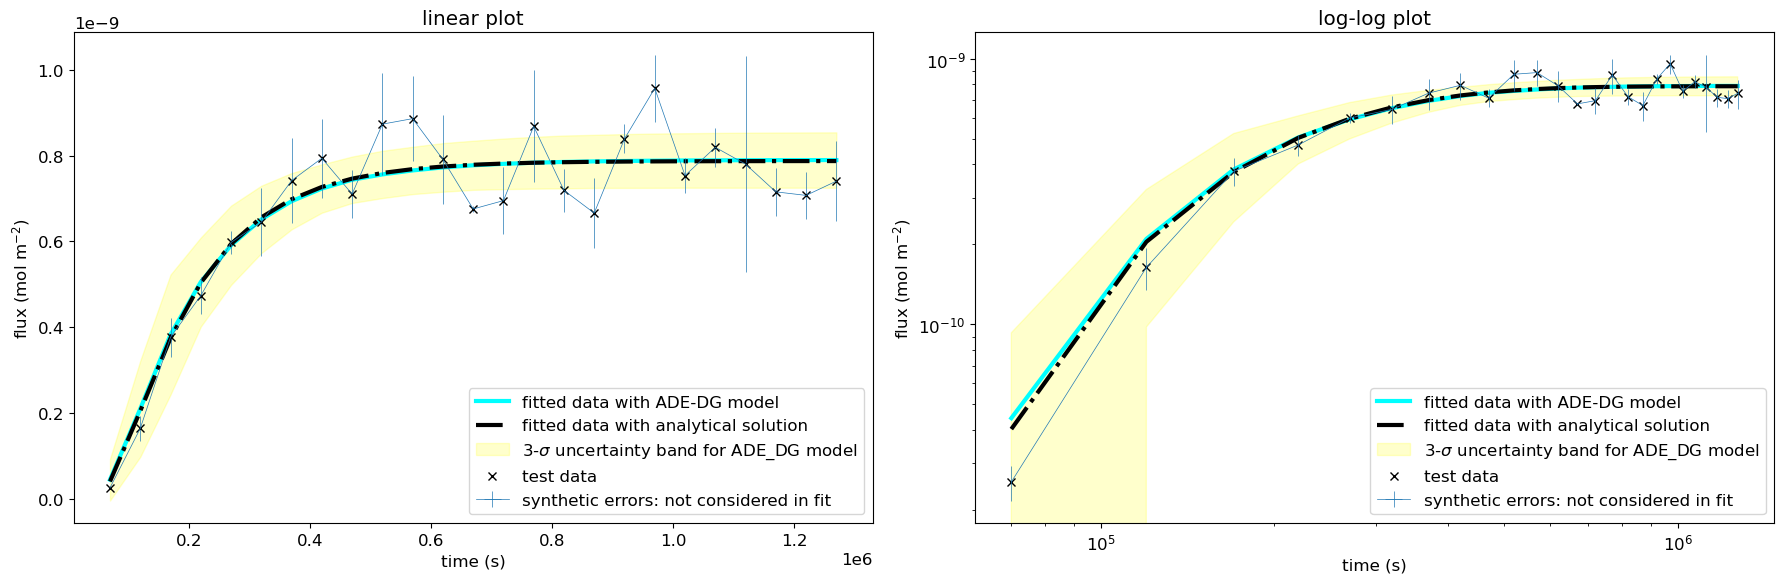

In [15]:
# firs we plot the fluxes ...aka breakthrough
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 6]

plt.rcParams.update({'lines.linewidth':3}) # plt parameters are used also for next plots! -> change again if necessary
#display(fluxes)
plt.rcParams.update({'font.size': 12}) # update font size..default is 10 !

fig, (ax0, ax1) = plt.subplots(1, 2) # two sub figures 

####### linear plot ##########
ax0.set_title('linear plot')



ax0.plot(tdat,result_ademodel.best_fit,linestyle='-',color="cyan",label='fitted data with ADE-DG model')
ax0.plot(tdat,result_analytic.best_fit,linestyle='-.',color="black",label='fitted data with analytical solution')

ax0.fill_between(tdat, result_ademodel.best_fit-dely_ade, result_ademodel.best_fit+dely_ade, color='yellow',
                 label=r'3-$\sigma$ uncertainty band for ADE_DG model',alpha=0.2)
alph=0.5 # transparancy

ax0.errorbar(tdat, fdat, xerr=0.0, yerr=udat,linewidth=0.5,label='synthetic errors: not considered in fit')
ax0.plot(tdat, fdat, label='test data', color="black",linestyle='',marker='x',linewidth=1.0)

#ax0.set_xlim(0.0,0.012)
#ax0.set_ylim(1e-16,1e-11)

#ax[0,0].set_ylim(-0.2, 1.4)
#ax[0,0].set_xlim(0, 1.0)

ax0.set_xlabel('time (s)')
ax0.set_ylabel(r'flux (mol m$^{-2}$)') # use latex style for formatting

ax0.legend(loc='lower right')
####### log-log plot ##########
ax1.set_title('log-log plot')

ax1.plot(tdat,result_ademodel.best_fit,linestyle='-',color="cyan",label='fitted data with ADE-DG model')
ax1.plot(tdat,result_analytic.best_fit,linestyle='-.',color="black",label='fitted data with analytical solution')

ax1.fill_between(tdat, result_ademodel.best_fit-dely_ade, result_ademodel.best_fit+dely_ade,color='yellow',
                 label=r'3-$\sigma$ uncertainty band for ADE_DG model',alpha=0.2)

ax1.plot(tdat, fdat, label='test data', color="black",linestyle='',marker='x',linewidth=1.0)
ax1.errorbar(tdat, fdat, xerr=0.0, yerr=udat,linewidth=0.5,label='synthetic errors: not considered in fit')

ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'flux (mol m$^{-2}$)') # use latex style for formatting

ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.set_xlim(0.0,0.012)
#ax1.set_ylim(1e-16,1e-11)

#ax[0,0].set_ylim(-0.2, 1.4)
#ax[0,0].set_xlim(0, 1.0)
ax1.legend(loc='lower right')


plt.tight_layout()  # no excess boundaries
plt.show() 
